In [1]:
import numpy as np
from model_2point import *


In [2]:


# Example usage:
# Define the function whose root is

phiA= 0.5
phiB = 1-phiA
chi = 1.0
rho0 = 100.0
nx = 1
zA = 1
zB = 1
tmax = 1.0
dt = 0.001
tol = 1e-10
maxiter = 1000
maxupdate = 10
np.random.seed(77)
# Generate arrays of complex numbers
wplus = np.random.normal(0, 1, nx) + 0j * np.random.normal(0, 1, nx)
wplus = wplus-np.mean(wplus)
wminus = np.random.normal(0, 1, nx) + 0j * np.random.normal(0, 1, nx)
w0 = np.vstack((wplus,wminus)).T
lambda_plus = 1.0
lambda_minus = 1.0
_model = model(chi,rho0,ensemble='grand')
_model.init_grandcanonical(zA,zB)

model_list = [_model.dHdw_compressible,_model.dHdw_weakcompressible,_model.dHdw_incompressible]
lambdat = np.array([lambda_plus,lambda_minus])
wlist = []
corrlist = []
sde = sde_int(w0,_model.dHdw_compressible,_model.wick,ensemble = 'grand')
sde.initialize_project(_model.dgdw,_model.gl,_model.dgldl,tol,maxiter,maxupdate)
w,t, = sde.Euler_Maruyama_Projected(tmax,dt,lambdat,SCFT = False)


[93.93077133-0.16315879j]
[5.34582364e+307+6.45361095e+307j]
[-inf+nanj]
nan


/home/timothy/ProjectionToySDE/python_version/model_2point.py:7: RuntimeWarning: divide by zero encountered in divide
  update= (gl(w0,lag_mult))/dgldl(w0,lag_mult)
/home/timothy/ProjectionToySDE/python_version/model_2point.py:7: RuntimeWarning: invalid value encountered in divide
  update= (gl(w0,lag_mult))/dgldl(w0,lag_mult)
/home/timothy/ProjectionToySDE/python_version/model_2point.py:12: RuntimeWarning: invalid value encountered in divide
  update[loc] = update[loc]/np.abs(update[loc])*maxupdate


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\det( \\left<\\delta\\rho_i \\delta\\rho_j\\right>-\\left<\\delta\\rho_i\\right> \\left< \\delta\\rho_j\\right>)$')

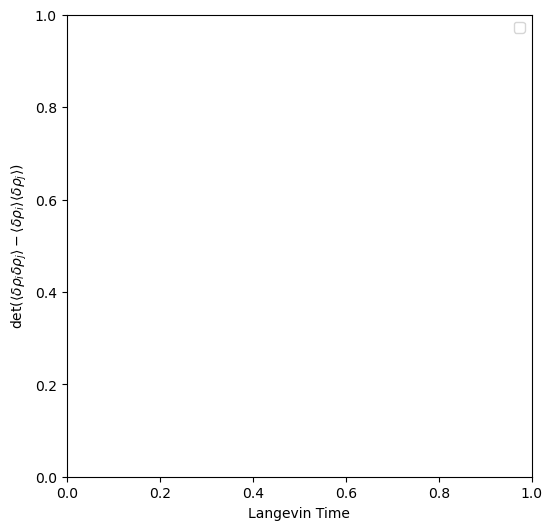

In [3]:
offset = 50
label = ['compressible','weak compressible','incompressible']
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))

for i, corr in enumerate(corrlist):
    corr = np.array(corr)
    plt.plot(t[offset:],np.linalg.det(corr[offset:,:,:])/rho0,label = label[i])
plt.legend()
plt.xlabel('Langevin Time')
plt.ylabel(r'$\det( \left<\delta\rho_i \delta\rho_j\right>-\left<\delta\rho_i\right> \left< \delta\rho_j\right>)$')
# plt.ylim(-10.0,5.0)

